# CMA/ES optimisation, 6th try: New Covariance, lapse + sigma out, summed LL90

Retry full CMA/ES sweep, with both lapse and sigma_out but now with fixed covariance for recall (I think).

Check if that makes any difference, hopefully not.

In [83]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [85]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [86]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

## Reload data

In [107]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_cmaes_11_2015/cmaes_bays09_ll90_6try_fixedcovariance_Mratiosigmaxlapseratesigmaout_repetitions5_070816
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-525d406c-3c1f-442d-98e5-5809f309b4f9.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_cmaes_11_2015/cmaes_bays09_ll90_6try_fixedcovariance_Mratiosigmaxlapseratesigmaout_repetitions5_070816


In [108]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [109]:
parameter_names_sorted

['ratio_conj', 'M', 'sigmax', 'lapse_rate', 'sigma_output']

In [110]:
df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)),
                             ('ratio_conj', candidates_parameters[:, 0]),
                             ('M', candidates_parameters[:, 1]),
                             ('sigmax', candidates_parameters[:, 2]),
                             ('lapse_rate', candidates_parameters[:, 3]),
                             ('sigma_output', candidates_parameters[:, 4]),
                             ('dist_nll90', np.ma.masked_greater(fitness.flatten(), 1e8)),
                            ])

In [111]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits.dist_nll90 < LL_max_cutoff]

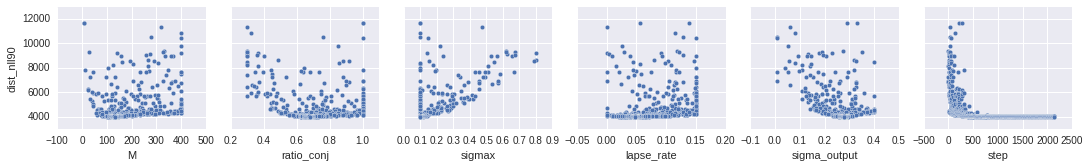

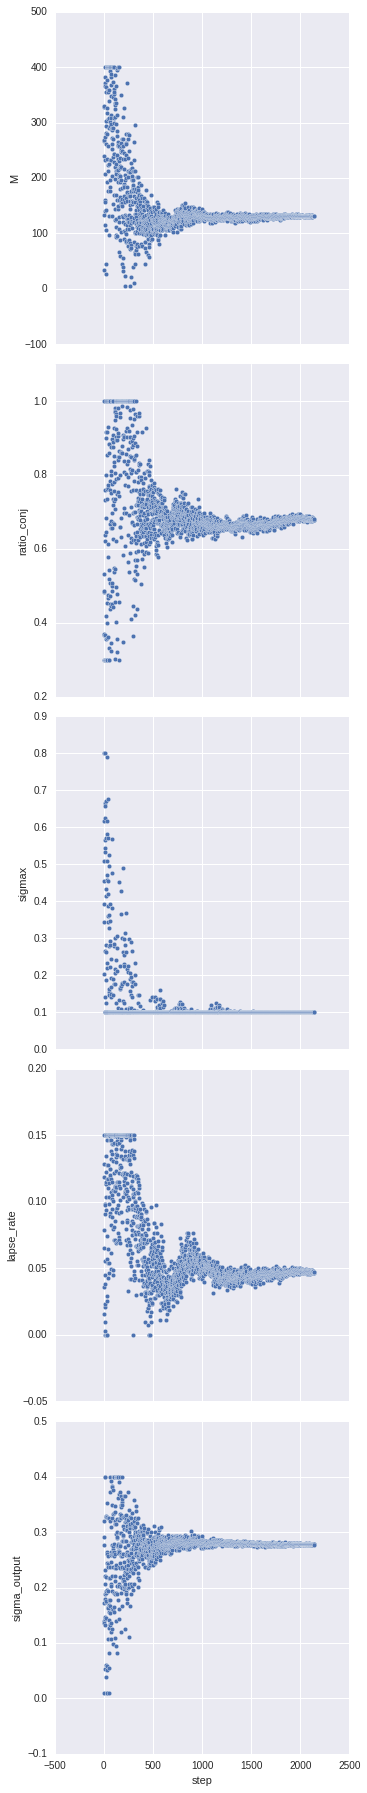

In [112]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_output', 'step'],
             y_vars=['dist_nll90']
            )

# Check learning
sns.pairplot(df_best_fits,
             y_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_output'],
             x_vars=['step'],
             size=5
            )

## Plotly Scatter3D

In [55]:
df_best_fits.columns

Index([u'step', u'ratio_conj', u'M', u'sigmax', u'lapse_rate', u'sigma_output',
       u'dist_nll90'],
      dtype='object')

In [56]:
result_to_color = np.array(df_best_fits.dist_nll90)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 7,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    title='Landscape for NLL90',
    scene=Scene(
        xaxis=XAxis(
            title='M',
        ),
        yaxis=YAxis(
            title='ratio_conj',
        ),
        zaxis=ZAxis(
            title='sigmax',
        )
    )
)
fig = Figure(data=data, layout=layout)
scatter3d_url = py.plot(fig)

In [57]:
dropdown_space = parameter_names_sorted
dropdown_default = 'lapse_rate'
metric_color_space = ['dist_nll90']
metric_color_default = 'dist_nll90'

g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.slider_index = 0
        self.marker_size = 8
        self.filter_results = slice(None, None)
        self.metric_color = metric_color_default
        self.dropdown_value = dropdown_default
        
        self.change_color_source(metric_color_default)
        self.change_dropdown_value(dropdown_default)
    
    def change_dropdown_value(self, new_value):
        self.dropdown_value = new_value
        
        # Update the axes
        self.axes_parameters = dropdown_space[:]
        self.axes_parameters.remove(self.dropdown_value)
        
        # Update the grid of the dropdown parameter
        self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        
    
    def change_color_source(self, new_value):
        self.metric_color = new_value
        self.result_to_color = np.array(df_best_fits[self.metric_color])
        self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
        self.col_min = np.min(self.result_to_color)
        self.col_max = np.max(self.result_to_color)
    
    def on_color_source_change(self, name, old_value, new_value):
        self.change_color_source(new_value)
        self.replot()
    
    def on_dropdown_change(self, name, old_value, new_value):
        self.change_dropdown_value(new_value)
        p_slider.description='%s [all]' % self.dropdown_value
        self.replot()
    
    def on_slider_change(self, name, old_value, new_value):
        self.slider_index = new_value
        
        if self.slider_index > -1:
            self.filter_results = self.dropparam_gridified[self.slider_index]
            self.marker_size = 6
            p_slider.description='%s [%f]' % (self.dropdown_value, self.dropparam_gridspace[self.slider_index])
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 6
            p_slider.description='%s [all]' % self.dropdown_value
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        self.replot()
        
    def replot(self):
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        new_trace = Scatter3d(
            x= df_best_fits[self.axes_parameters[0]][self.filter_results],
            y= df_best_fits[self.axes_parameters[1]][self.filter_results],
            z= df_best_fits[self.axes_parameters[2]][self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = self.result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=self.col_min,
                cmax=self.col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
        g.relayout({'title' : "Landscape for %s" % self.metric_color,
                    'scene.xaxis.title': self.axes_parameters[0],
                    'scene.yaxis.title': self.axes_parameters[1],
                    'scene.zaxis.title': self.axes_parameters[2],
                    })
        g.add_traces(new_trace)

p_state = shifter()
p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
p_slider.description='%s [all]' % p_state.dropdown_value

p_slider.on_trait_change(p_state.on_slider_change, 'value')
p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

p_state.replot()

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:97: DeprecationWarning:

on_trait_change is deprecated: use observe instead

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:98: DeprecationWarning:

on_trait_change is deprecated: use observe instead

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:99: DeprecationWarning:

on_trait_change is deprecated: use observe instead



In [62]:
display(p_metric_drop)
display(p_variable_drop)
display(p_slider)
display(g)

## Check parameters values obtained

In [93]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).iloc[0]
df_bestparams

step            1659.000000
ratio_conj         0.667979
M                130.108763
sigmax             0.100000
lapse_rate         0.044917
sigma_output       0.279058
dist_nll90      4001.745275
Name: 1659, dtype: float64

In [94]:
%env WORKDIR_DROP

'/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory'

In [100]:
%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_allmetrics --inference_method none  --num_samples 200  --renormalize_sigmax \
--autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09 \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(df_bestparams['M'])} --sigmax {df_bestparams['sigmax']} \
--ratio_conj {df_bestparams['ratio_conj']} --sigma_output {df_bestparams['sigma_output']} \
--filter_datapoints_size 1500 --filter_datapoints_selection 'random'

Arguments: ['--action_to_do', 'launcher_do_fitexperiment_allmetrics', '--inference_method', 'none', '--num_samples', '200', '--renormalize_sigmax', '--autoset_parameters', '--code_type', 'mixed', '--sigmay', '0.00001', '--experiment_id', 'bays09', '--lapse_rate', '0.0449174690251', '--M', '130', '--sigmax', '0.1', '--ratio_conj', '0.667979015165', '--sigma_output', '0.27905831348', '--filter_datapoints_size', '1500', '--filter_datapoints_selection', 'random']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'action_to_do': 'launcher_do_fitexperiment_allmetrics', 'code_type': 'mixed', 'renormalize_sig

In [101]:
plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

Doing Paper plots for bays09. 
Fig5 1, Fig6 1, Fig13 1


DATA T 1
DATA T 2
mu: 1.082, kappa: 0.049
{'R': 36.81578133480852, 'u': 0.63105830512728389, 'pvalue': 0.26400120106126324, 'V': 17.282243440959572}
DATA T 4
mu: -0.002, kappa: 0.099
{'R': 222.82053476246375, 'u': 4.6974584915402646, 'pvalue': 1.3170934763939712e-06, 'V': 222.82002071049047}
DATA T 6
mu: 0.079, kappa: 0.117
{'R': 438.12787929238908, 'u': 7.1325356723057141, 'pvalue': 4.9271697832864447e-13, 'V': 436.77682423369907}


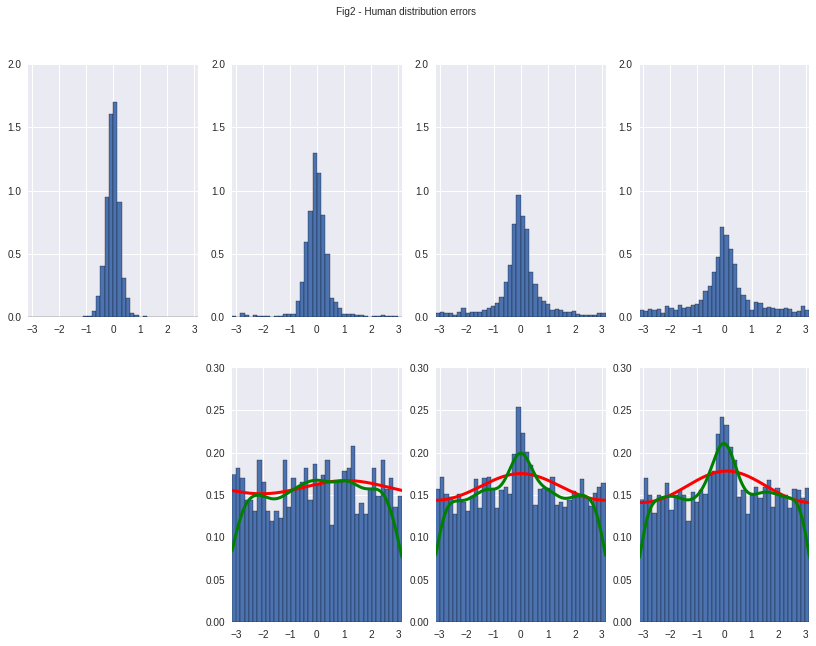

In [ ]:
axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

MODEL T 1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -439.74
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 08.08 16:50                                                     
Loglikelihood: -438.01
top 90% loglike: -6.24
MODEL T 2
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -603.09
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 08.08 16:51                                                     
Loglikelihood: -531.37
top 90% loglike: -92.15
mu: 0.134, kappa: 0.000
{'R': 56.260895842662812, 'u': -0.83396365170504849, 'pvalue': 0.79784926659873245, 'V': -22.839035208911838}
MODEL T 4
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -853.15
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 08.08 16:53                                                     
Loglikelihood: -754.35
top 90% loglike: -303.74
mu: 0.092, kappa: 0.091
{'

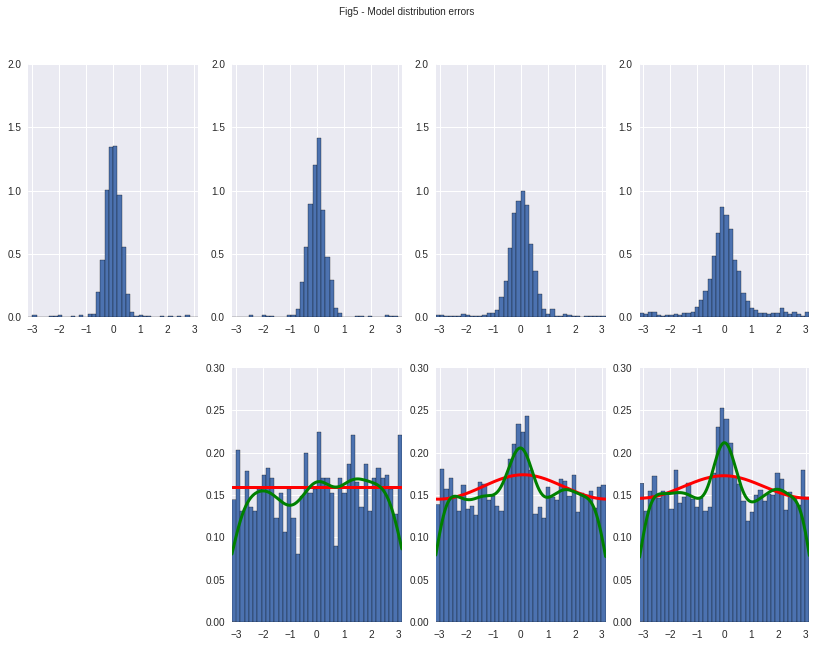

In [105]:
axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

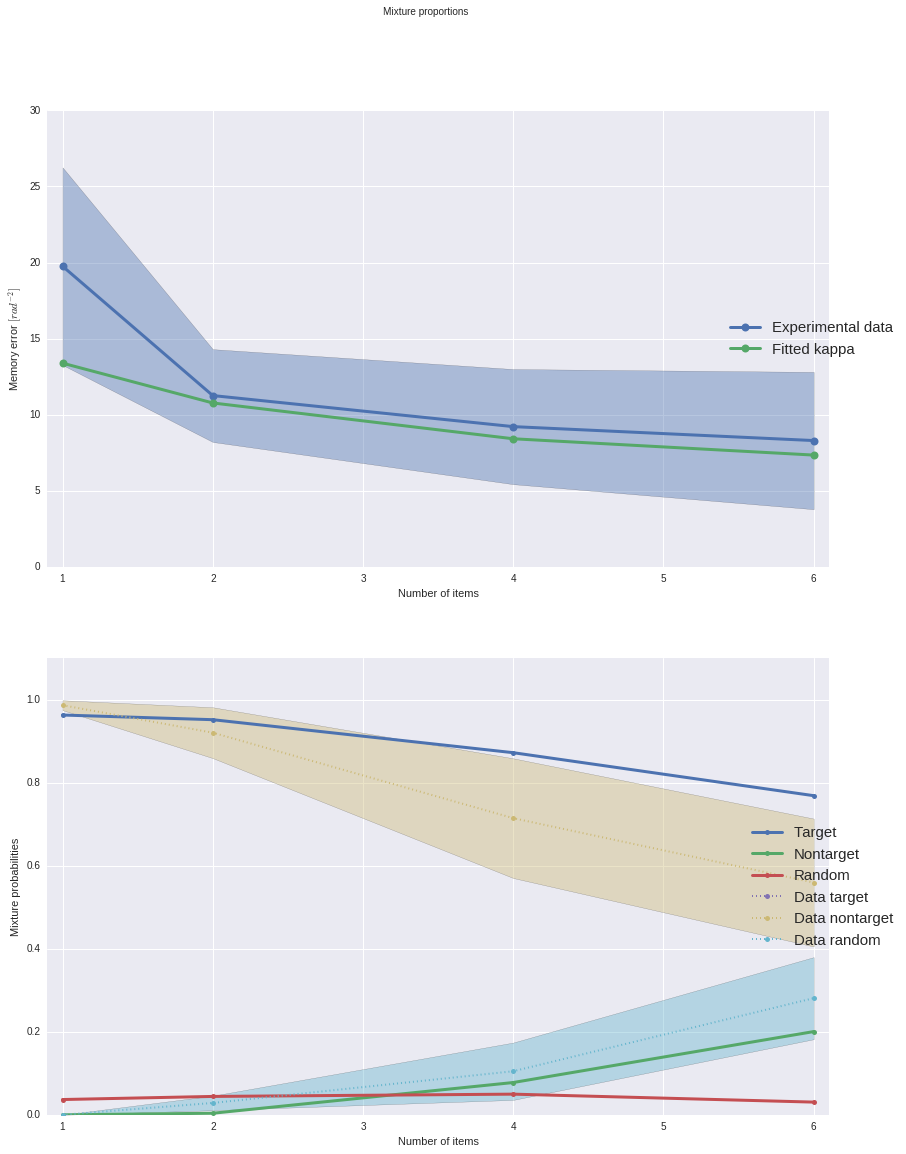

In [106]:
axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13()